# Hyperbolic Embedding Methods for Medical Entity Relations
<br>

**Drew Wilimitis** <br> 
Department of Biomedical Informatics, Vanderbilt University Medical Center

![title](images/three_models.png)

### Abstract :
Electronic Health Records are other sources of clinical data are often unstructured, non-standardized, and contain heterogeneous data. This presents a significant challenge for building accurate and robust predictive models, as most standard supervised learning algorithms require uniformly formatted training datasets with informative feature vectors. Therefore, it is necessary to learn representations of these datasets that preserve their underlying, multi-layered relationships. There is a wide variety of methods for representation learning of Electronic Health Records **[1]**, including attempts to represent hierarchical relationships often found within taxonomies and concept networks. We compare a variety of hyperbolic embedding algorithms and their ability to learn low-distortion embeddings of ICD-9 codes. We then demonstrate the utility of these embeddings and the insights they reveal.

**Rough outline:**
2. Background Overview of Hyperbolic Geometry
3. Hyperbolic Embeddings <br>
a. Poincare Embedding Algorithm (gensim, pytorch) <br>
b. Lorentz Embedding (pytorch)<br>
c. Coalescent Embedding (laplacian based in R) <br>
d. Others: Lorentzian Distance Learning, hMDS, etc. <br>
4.  Evaluation Comparison (Between Euclidean & Earlier Approach) 
5. Apply Hyperbolic KMeans/Clustering?
6. Apply to real EHR data and build model with embedding features?

# Initial Data and Pre-processing Exploration

## ICD-9 Data Source 1
**source of data and cleaning steps:** https://github.com/brettbj/PoincareEmbeddings/tree/master/data

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline
import networkx as nx
import sys
import os

# ignore warnings
import warnings
warnings.filterwarnings('ignore');

# display multiple outputs within a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all";

In [2]:
all_codes = pd.read_csv('data/tmp/allcodes.csv', sep="|" , encoding='latin1', false_values=['"'])
majors = pd.read_csv('data/tmp/majors.csv', sep="|")
chapters = pd.read_csv('data/tmp/chapters.csv', sep="|").transpose()
sub_chapters = pd.read_csv('./data/tmp/subchapters.csv', sep="|").transpose()

df = pd.DataFrame(columns=['parent', 'child'])
# print(all_codes.head(3))

# handle chapters
chapters = chapters.reset_index()
chapters.columns = ['name', 'start', 'end']
chapters['range'] = 'c_' + chapters['start'].map(str) + '_' + chapters['end'].map(str)

chap_name_dict = dict(zip(chapters['name'], chapters['range']))
chap_range_dict = dict(zip(chapters['range'], chapters['name']))

sub_chapters = sub_chapters.reset_index()
sub_chapters.columns = ['name', 'start', 'end']
sub_chapters['range'] = 's_' + sub_chapters['start'].map(str) + '_' + sub_chapters['end'].map(str)

subchap_name_dict = dict(zip(sub_chapters['name'], sub_chapters['range']))
subchap_range_dict = dict(zip(sub_chapters['range'], sub_chapters['name']))

In [3]:
all_codes.head()
all_codes.shape

,code,billable,short_desc,long_desc,three_digit,major,sub_chapter,chapter
1,001,False,Cholera,Cholera,001,Cholera,Intestinal Infectious Diseases,Infectious And Parasitic Diseases
2,0010,True,Cholera d/t vib cholerae,Cholera due to vibrio cholerae,001,Cholera,Intestinal Infectious Diseases,Infectious And Parasitic Diseases
3,0011,True,Cholera d/t vib el tor,Cholera due to vibrio cholerae el tor,001,Cholera,Intestinal Infectious Diseases,Infectious And Parasitic Diseases
4,0019,True,Cholera NOS,"Cholera, unspecified",001,Cholera,Intestinal Infectious Diseases,Infectious And Parasitic Diseases
5,002,False,Typhoid and paratyphoid fevers,Typhoid and paratyphoid fevers,002,Typhoid and paratyphoid fevers,Intestinal Infectious Diseases,Infectious And Parasitic Diseases


(17561, 8)

In [4]:
majors.head()
majors.shape

,x
Cholera,001
Typhoid and paratyphoid fevers,002
Other salmonella infections,003
Shigellosis,004
Other food poisoning (bacterial),005


(1234, 1)

In [5]:
chapters.head()
chapters.shape

,name,start,end,range
0,Infectious.And.Parasitic.Diseases,1,139,c_1_139
1,Neoplasms,140,239,c_140_239
2,Endocrine..Nutritional.And.Metabolic.Diseases....,240,279,c_240_279
3,Diseases.Of.The.Blood.And.Blood.Forming.Organs,280,289,c_280_289
4,Mental.Disorders,290,319,c_290_319


(19, 4)

In [6]:
sub_chapters.head()
sub_chapters.tail()
sub_chapters.shape

,name,start,end,range
0,Intestinal.Infectious.Diseases,1,9,s_1_9
1,Tuberculosis,10,18,s_10_18
2,Zoonotic.Bacterial.Diseases,20,27,s_20_27
3,Other.Bacterial.Diseases,30,41,s_30_41
4,Human.Immunodeficiency.Virus..Hiv..Infection,42,42,s_42_42


,name,start,end,range
159,Homicide.And.Injury.Purposely.Inflicted.By.Oth...,E960,E969,s_E960_E969
160,Legal.Intervention,E970,E978,s_E970_E978
161,Terrorism,E979,E979,s_E979_E979
162,Injury.Undetermined.Whether.Accidentally.Or.Pu...,E980,E989,s_E980_E989
163,Injury.Resulting.From.Operations.Of.War,E990,E999,s_E990_E999


(164, 4)

In [7]:
# filter letter codes for now (last two "Supplementary Classification" chapters)
print(chapters.shape)
chapters = chapters[:17]
print(chapters.shape)

print(majors.shape)
majors = majors[:928]
print(majors.shape)

sub_chapters = sub_chapters[:119]

(19, 4)
(17, 4)
(1234, 1)
(928, 1)


In [8]:
# Note: this approach excludes base level codes from edge relations
# only majors, subchapters, and chapters are included as nodes
relations = []
for i, major in majors.iterrows():
    # chapter first
    # then subchapter
    relations.append((major['x'], chapters.loc[(int(major['x']) >= chapters['start'].astype(int))
                                   & (int(major['x']) <= chapters['end'].astype(int))]['range'].values[0]))    
    sub_chapter_formajor = sub_chapters.loc[(int(major['x']) >= sub_chapters['start'].astype(int))
                                       & (int(major['x']) <= sub_chapters['end'].astype(int))]['range'].values
   
    if len(sub_chapter_formajor) == 1:
        relations.append((major['x'], sub_chapter_formajor[0]))
        

for i, sub in sub_chapters.iterrows():
    relations.append((sub['range'], chapters.loc[(int(sub['start']) >= chapters['start'].astype(int))
                                   & (int(sub['start']) <= chapters['end'].astype(int))]['range'].values[0]))

# adding 'center' as the very top of the hierarchy/taxonomy?
#for i, chapter in chapters.iterrows():
#    relations.append((chapter['range'], 'center'))

    
print(relations[-50:])
print(len(relations))

[('s_590_599', 'c_580_629'), ('s_600_608', 'c_580_629'), ('s_610_612', 'c_580_629'), ('s_614_616', 'c_580_629'), ('s_617_629', 'c_580_629'), ('s_630_633', 'c_630_679'), ('s_634_639', 'c_630_679'), ('s_640_649', 'c_630_679'), ('s_650_659', 'c_630_679'), ('s_660_669', 'c_630_679'), ('s_670_677', 'c_630_679'), ('s_678_679', 'c_630_679'), ('s_680_686', 'c_680_709'), ('s_690_698', 'c_680_709'), ('s_700_709', 'c_680_709'), ('s_710_719', 'c_710_739'), ('s_720_724', 'c_710_739'), ('s_725_729', 'c_710_739'), ('s_730_739', 'c_710_739'), ('s_760_763', 'c_760_779'), ('s_764_779', 'c_760_779'), ('s_780_789', 'c_780_799'), ('s_790_796', 'c_780_799'), ('s_797_799', 'c_780_799'), ('s_800_829', 'c_800_999'), ('s_800_804', 'c_800_999'), ('s_805_809', 'c_800_999'), ('s_810_819', 'c_800_999'), ('s_820_829', 'c_800_999'), ('s_830_839', 'c_800_999'), ('s_840_848', 'c_800_999'), ('s_850_854', 'c_800_999'), ('s_860_869', 'c_800_999'), ('s_870_897', 'c_800_999'), ('s_870_879', 'c_800_999'), ('s_880_887', 'c_80

### Exploratory graph analysis with networkx
Now we define a graph with these relations as edges, and use `networkx` to examine the graph structure.

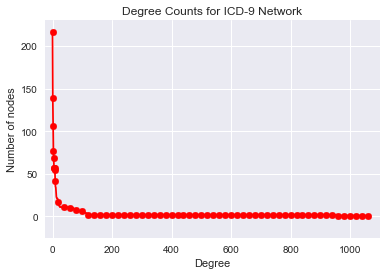

In [9]:
import collections
import networkx as nx
G = nx.Graph()
G.add_edges_from(relations)

# degree sequence
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

# plot number of nodes that have given degree values
plt.figure()
plt.grid(True)
plt.plot(degree_sequence, 'r') # in-degree
node_ix = list(np.arange(0,10)) + list(np.arange(20, len(degree_sequence), 20))
plt.scatter(node_ix, np.array(degree_sequence)[node_ix], c='r', s=45)
plt.xlabel('Degree')
plt.ylabel('Number of nodes')
plt.title('Degree Counts for ICD-9 Network')
plt.ylim([-25, 230])
plt.xlim([-25, 1100])
plt.show();

This distribution shows a heavily skewed distribution of in-degree, which indicates that the network has a hierarchical structure with a few central hub nodes (those that represent chapters).

In [10]:
# Clustering coefficient of all nodes (in a dictionary)
clust_coefficients = nx.clustering(G)
# Average clustering coefficient
ccs = nx.clustering(G)
avg_clust = sum(ccs.values()) / len(ccs)
print('Avg Clustering Coefficient:', avg_clust)

# get largest connected components in G
G_components = [c for c in sorted(nx.connected_components(G), key=len, reverse=True)]
component_sizes = [len(c) for c in G_components]
print('{} connected component(s) with respective node sizes {}'.format(len(G_components),component_sizes))

component_graphs = [G.subgraph(c).copy() for c in G_components]
bc_vals = [np.mean(list(nx.betweenness_centrality(cg).values())) for cg in component_graphs]
print('Average betweenness centrality: ', np.mean(bc_vals))

Avg Clustering Coefficient: 0.8124787447825227
17 connected component(s) with respective node sizes [217, 140, 107, 78, 70, 58, 58, 58, 55, 43, 36, 35, 30, 24, 23, 21, 11]
Average betweenness centrality:  0.025815252150932506


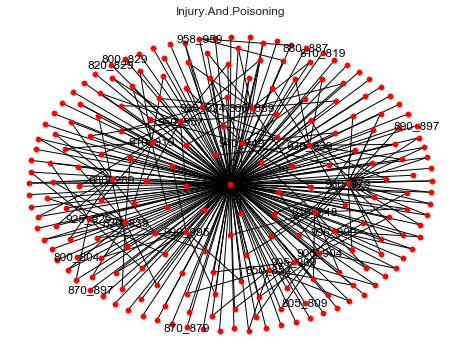

In [11]:
# now we select the first component and plot the sub-graph 
c = G_components[0]
C = G.subgraph(c).copy()
l1 = list(C.nodes())
subchaps = set(l1).intersection(set(subchap_range_dict.keys()))
sub_labels = {k:subchap_range_dict[k] for k in subchaps}
chaps = set(l1).intersection(set(chap_range_dict.keys()))
chap_labels = {k:chap_range_dict[k] for k in chaps}

# define figure with positions for all nodes
plt.figure(figsize=(8, 6))
pos=nx.kamada_kawai_layout(C)

# nodes and edges
nx.draw_networkx_nodes(C,pos,node_size=30)
nx.draw_networkx_edges(C,pos)

# add labels and plot
nx.draw_networkx_labels(C,pos,{s:s[2:] for s in subchaps},font_size=12)
if len(list(chaps)) == 1:
    plt.title(chap_labels[list(chaps)[0]])
plt.axis('off')
plt.show(); # display

### Prepare input data and train poincare embeddings

In [12]:
# optionally add 'center' as the very top of the hierarchy/taxonomy
for i, chapter in chapters.iterrows():
    relations.append((chapter['range'], 'center'))

# store edges as a dataframe and write to disk
icd_relations = pd.DataFrame(relations, columns=['u', 'v'])
icd_relations['u'] = icd_relations['u'].astype('str')
icd_relations.info()
icd_relations.head()
icd_relations.to_csv('data/icd_data/icd_relations.csv', index=None)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1896 entries, 0 to 1895
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   u       1896 non-null   object
 1   v       1896 non-null   object
dtypes: object(2)
memory usage: 29.8+ KB


,u,v
0,001,c_1_139
1,001,s_1_9
2,002,c_1_139
3,002,s_1_9
4,003,c_1_139


In [13]:
# import modules within repository
sys.path.append('C:\\Users\\dreww\\Desktop\\hyperbolic-learning\\utils')
sys.path.append('C:\\Users\\dreww\\Desktop\\hyperbolic-learning\\poincaré_embeddings')
from embed import *
from poincare_embedding import plot_embedding
#pd.read_csv('data/icd_data/icd_relations.csv')

In [14]:
# train poincare embeddings and save output embedding coordinates
fin = 'data/icd_data/icd_relations.csv' # input path with stored relations
fout = 'data/icd_data/icd_embeddings.csv' # output path to write embedding coordinates

# call function to train gensim's poincare embedding model
train_embeddings(input_path=fin, delimiter=',', output_path=fout, epochs=100, burn_in_alpha=0.01, 
                 batch_size=10, alpha=0.1, negative=20, print_every=100)

INFO:gensim.models.poincare:loading relations from train data..
INFO:gensim.models.poincare:loaded 1897 relations from train data, 1067 nodes
INFO:gensim.models.poincare:training model of size 2 with 1 workers on 1897 relations for 100 epochs and 10 burn-in epochs, using lr=0.10000 burn-in lr=0.01000 negative=20
INFO:gensim.models.poincare:starting burn-in (10 epochs)----------------------------------------
INFO:gensim.models.poincare:training on epoch 1, examples #990-#1000, loss: 30.46
INFO:gensim.models.poincare:time taken for 1000 examples: 0.33 s, 3075.68 examples / s
INFO:gensim.models.poincare:training on epoch 2, examples #990-#1000, loss: 30.42
INFO:gensim.models.poincare:time taken for 1000 examples: 0.25 s, 3932.04 examples / s
INFO:gensim.models.poincare:training on epoch 3, examples #990-#1000, loss: 30.36
INFO:gensim.models.poincare:time taken for 1000 examples: 0.32 s, 3153.06 examples / s
INFO:gensim.models.poincare:training on epoch 4, examples #990-#1000, loss: 30.23


INFO:gensim.models.poincare:time taken for 1000 examples: 0.27 s, 3686.29 examples / s
INFO:gensim.models.poincare:training on epoch 37, examples #990-#1000, loss: 9.67
INFO:gensim.models.poincare:time taken for 1000 examples: 0.27 s, 3769.49 examples / s
INFO:gensim.models.poincare:training on epoch 38, examples #990-#1000, loss: 9.18
INFO:gensim.models.poincare:time taken for 1000 examples: 0.27 s, 3672.75 examples / s
INFO:gensim.models.poincare:training on epoch 39, examples #990-#1000, loss: 9.12
INFO:gensim.models.poincare:time taken for 1000 examples: 0.24 s, 4212.93 examples / s
INFO:gensim.models.poincare:training on epoch 40, examples #990-#1000, loss: 9.02
INFO:gensim.models.poincare:time taken for 1000 examples: 0.24 s, 4109.33 examples / s
INFO:gensim.models.poincare:training on epoch 41, examples #990-#1000, loss: 8.77
INFO:gensim.models.poincare:time taken for 1000 examples: 0.27 s, 3686.40 examples / s
INFO:gensim.models.poincare:training on epoch 42, examples #990-#100

INFO:gensim.models.poincare:training on epoch 85, examples #990-#1000, loss: 6.63
INFO:gensim.models.poincare:time taken for 1000 examples: 0.21 s, 4773.99 examples / s
INFO:gensim.models.poincare:training on epoch 86, examples #990-#1000, loss: 6.61
INFO:gensim.models.poincare:time taken for 1000 examples: 0.24 s, 4194.66 examples / s
INFO:gensim.models.poincare:training on epoch 87, examples #990-#1000, loss: 6.61
INFO:gensim.models.poincare:time taken for 1000 examples: 0.21 s, 4796.74 examples / s
INFO:gensim.models.poincare:training on epoch 88, examples #990-#1000, loss: 6.50
INFO:gensim.models.poincare:time taken for 1000 examples: 0.23 s, 4377.89 examples / s
INFO:gensim.models.poincare:training on epoch 89, examples #990-#1000, loss: 6.07
INFO:gensim.models.poincare:time taken for 1000 examples: 0.23 s, 4359.47 examples / s
INFO:gensim.models.poincare:training on epoch 90, examples #990-#1000, loss: 6.44
INFO:gensim.models.poincare:time taken for 1000 examples: 0.24 s, 4177.83

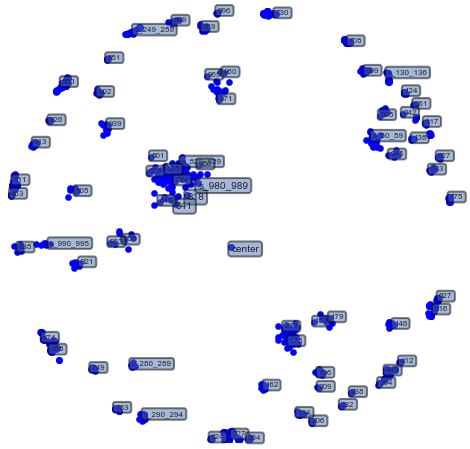

In [15]:
# plot poincare embeddings
emb = load_embeddings('data/icd_data/icd_embeddings.csv')
emb_data = np.array(emb.iloc[:, 1:3])
emb_dict = dict(zip(emb.node.values, emb_data))
plot_embedding(emb_dict, plot_frac=1, label_frac=0.001) #title='Poincaré Embeddings: ICD-9')

## ICD-9 Data Source 2
**source:** https://github.com/kshedden/icd9

In [16]:
# Note: this approach includes all code levels (resulting in a lot more nodes and edges)
import json
sys.path.append('C:\\Users\\dreww\\Desktop')
from icd9 import icd9
from itertools import combinations
icd_data = icd9.icd9Hierarchy
drop_lettered_chapters = True # optionally drop supplemental lettered chapter codes
icd_data = [d for d in icd_data if d['icd9'][0] not in ['E', 'V']]

# store code ranges for each subchapter
subchapter_name_range = {}
for i, codes in enumerate(icd_data):
    try:
        if codes['subchapter'] not in subchapter_name_range.keys():
            if i > 0:
                subchapter_name_range[new_sub] = start + '_' + end
            new_sub = codes['subchapter']
            start = codes['threedigit']
        end = codes['threedigit']
    except KeyError:
        continue
subchapter_range_name = {v:k for k,v in subchapter_name_range.items()}

# store code ranges for each chapter
chapters = icd9.icd9Chapters
if drop_lettered_chapters:
    drop1 = chapters.pop('Supplementary Classification Of External Causes Of Injury And Poisoning')
    drop2 = chapters.pop('Supplementary Classification Of Factors Influencing Health Status And Contact With Health Services')
chapter_name_range = {}
for k,v in chapters.items():
    chapter_name_range[k] = v[0] + '_' + v[1]
chapter_range_name = {v:k for k,v in chapter_name_range.items()}

In [17]:
# get list of edge pairs
icd_relations = []
levels = {0:'icd9', 1: 'threedigit', 2: 'subchapter', 3: 'chapter'}
for codes in icd_data:
    for rel in combinations([1, 2, 3], 2): # using [0, 1, 2, 3] would include base-level codes
        try:
            edge = [codes[levels[rel[0]]], codes[levels[rel[1]]]]
            if edge not in icd_relations:
                icd_relations.append(edge)
        except KeyError:
            continue
            
# optionally add edges from each chapter to highest level, center node            
for chapter in chapter_name_range.values():
    icd_relations.append([chapter, 'ICD-9_Diagnoses'])

# define edge relations as a dataframe            
icd_df = pd.DataFrame(icd_relations, columns=['u', 'v'])
icd_df['u'] = icd_df.u.apply(lambda x: subchapter_name_range[x] if x in subchapter_name_range.keys() else x)
icd_df['v'] = icd_df.v.apply(lambda x: subchapter_name_range[x] if x in subchapter_name_range.keys() else x)
icd_df['v'] = icd_df.v.apply(lambda x: chapter_name_range[x] if x in chapter_name_range.keys() else x)
icd_df.head()
icd_df.info()
icd_df.to_csv('data/icd_data/icd_full_relations.csv', index=None)

,u,v
0,001,001_009
1,001,001_139
2,001_009,001_139
3,002,001_009
4,002,001_139


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1956 entries, 0 to 1955
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   u       1956 non-null   object
 1   v       1956 non-null   object
dtypes: object(2)
memory usage: 30.7+ KB


In [18]:
# define mappings between chapter name & range to integer class labels
chapter_name_label = {}
for i, k in enumerate(chapters.keys()):
    chapter_name_label[k] = i
chapter_range_label = {k:i for i, k in enumerate(chapter_range_name)}

# assign each node to its chapter class label
node_labels = {}
for i in range(icd_df.shape[0]):
    u = icd_df.iloc[i, 0]
    v = icd_df.iloc[i, 1]
    if v in chapter_range_label.keys():
        node_labels[u] = chapter_range_label[v]
for k, v in chapter_range_label.items():
    node_labels[k] = v

### Train poincare model and visualize 2-D embedding

In [19]:
# train poincare embeddings and save output embedding coordinates
fin = 'data/icd_data/icd_full_relations.csv' # input path with stored relations
fout = 'data/icd_data/icd_full_embeddings_tmp.csv' # output path to write embedding coordinates

# call function to train gensim's poincare embedding model
train_embeddings(input_path=fin, delimiter=',', output_path=fout, epochs=100, burn_in_alpha=0.01, 
                 batch_size=10, burn_in=10, alpha=0.1, negative=20)

INFO:gensim.models.poincare:loading relations from train data..
INFO:gensim.models.poincare:loaded 1957 relations from train data, 1061 nodes
INFO:gensim.models.poincare:training model of size 2 with 1 workers on 1957 relations for 100 epochs and 10 burn-in epochs, using lr=0.10000 burn-in lr=0.01000 negative=20
INFO:gensim.models.poincare:starting burn-in (10 epochs)----------------------------------------
INFO:gensim.models.poincare:burn-in finished
INFO:gensim.models.poincare:starting training (100 epochs)----------------------------------------
INFO:gensim.models.poincare:training finished
INFO:gensim.models.utils_any2vec:storing 1061x2 projection weights into data/icd_data/icd_full_embeddings_tmp.csv


,node,x,y
0,800_999,-0.304720,-0.118744
1,001_139,0.453165,0.190884
2,140_239,0.665936,-0.607616
3,320_389,-0.790279,-0.566815
4,390_459,0.048185,-0.939577


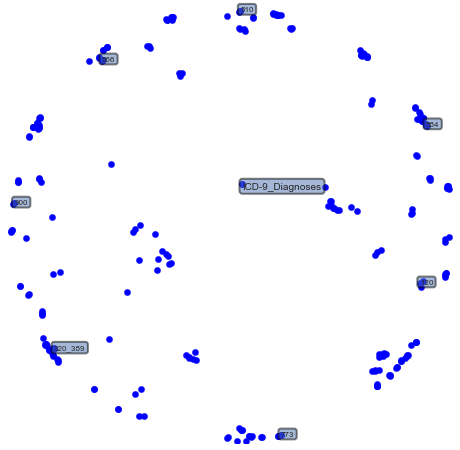

In [20]:
# load embedding coordinates and prepare data for plotting in the poincare disk
emb = load_embeddings('data/icd_data/icd_full_embeddings_tmp.csv', delim=' ')
emb.head()
emb_data = np.array(emb.iloc[:, 1:3])
emb_dict = dict(zip(emb.node.values, emb_data))
plot_embedding(emb_dict, plot_frac=0.25, label_frac=0.1)

In [21]:
sys.path.append('C:\\Users\\dreww\\Desktop\\vu-informatics\\utils')
from poincare_viz_icd import *
edge_list = [list(arr) for arr in np.array(icd_df)]
labels = emb[emb.node != 'ICD-9_Diagnoses'].node.apply(lambda x: node_labels[x])
chapter_label_range = {v:k for k,v in chapter_range_label.items()}

In [22]:
def plot_poincare_icd(emb, labels, edge_list, legend_headers=None, height=8, width=9, save=False,
                      plot_frac=1, edge_frac=1, add_labels=False, label_dict=None, label_frac=0.001):
    # Note: parameter 'emb' expects data frame with node ids and coords
    emb.columns = ['node', 'x', 'y']
    n_classes = len(np.unique(labels))
    plt.figure(figsize=(width, height))
    plt.xlim([-1.0, 1.0])
    plt.ylim([-1.0,1.0])
    ax = plt.gca()
    circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.8)
    ax.add_patch(circ)
    
    # set colormap,
    if n_classes <= 12:
        colors = ['b', 'r', 'g', 'y', 'm', 'c', 'k', 'silver', 'lime', 'skyblue', 'maroon', 'darkorange']
    elif 12 < n_classes <= 20:
        colors = [i for i in plt.cm.get_cmap('tab20').colors]
    else:
        cmap = plt.cm.get_cmap(name='viridis')
        colors = cmap(np.linspace(0, 1, n_classes))

    # plot embedding coordinates
    emb_data = np.array(emb[emb.node != 'ICD-9_Diagnoses'].iloc[:, 1:3])
    for i in range(n_classes):
        plt.scatter(emb_data[(labels == i), 0], emb_data[(labels == i), 1], color = colors[i],
                    alpha=0.9, edgecolors='black', s=75, label=i)
    # plot central highest level node
    center_coords = emb[emb.node == 'ICD-9_Diagnoses'].iloc[:, 1:3].values[0]
    label_dict['ICD-9_Diagnoses'] = center_coords
    plt.scatter(center_coords[0], center_coords[1], s=70, c='black')
    
    # plot edges
    for i in range(int(len(edge_list) * edge_frac)):
        x1 = emb.loc[(emb.iloc[:, 0] == edge_list[i][0]), ['x', 'y']].values[0]
        x2 = emb.loc[(emb.node == edge_list[i][1]), ['x', 'y']].values[0]
        _ = plt.plot([x1[0], x2[0]], [x1[1], x2[1]], '--', c='black', linewidth=1, alpha=0.55)
    
    # add labels to embeddings,
    if add_labels and label_dict != None:
        plt.grid('off')
        plt.axis('off')
        embed_vals = np.array(list(label_dict.values()))
        keys = list(label_dict.keys())
        # set threshhold to limit plotting labels too close together
        min_dist_2 = label_frac * max(embed_vals.max(axis=0) - embed_vals.min(axis=0)) ** 2
        labeled_vals = np.array([2*embed_vals.max(axis=0)])
        n = int(plot_frac*len(embed_vals))
        for i in np.random.permutation(len(embed_vals))[:n]:
            if np.min(dist_squared(embed_vals[i], labeled_vals, axis=1)) < min_dist_2:
                continue
            else:
                props = dict(boxstyle='round', lw=1, edgecolor='black', alpha=0.65)
                _ = ax.text(embed_vals[i][0], embed_vals[i][1]+0.06, s=keys[i],
                            size=10, fontsize=10, verticalalignment='top', bbox=props)
                labeled_vals = np.vstack((labeled_vals, embed_vals[i]))
    plt.suptitle('ICD-9: Poicare Embedding', size=20)
    leg_handles, leg_labels = ax.get_legend_handles_labels()
    if legend_headers != None:
        # get display labels and put legend to the right of the current axis
        new_labels = [legend_headers[int(l)] for l in leg_labels]
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.75, box.height])
        ax.legend(leg_handles, new_labels, loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=14,
                  frameon=True, edgecolor='black', fancybox=True, framealpha=1, shadow=True, borderpad=1)
    if save:
        plt.savefig('images/poincare_icd9.png')
    plt.show();

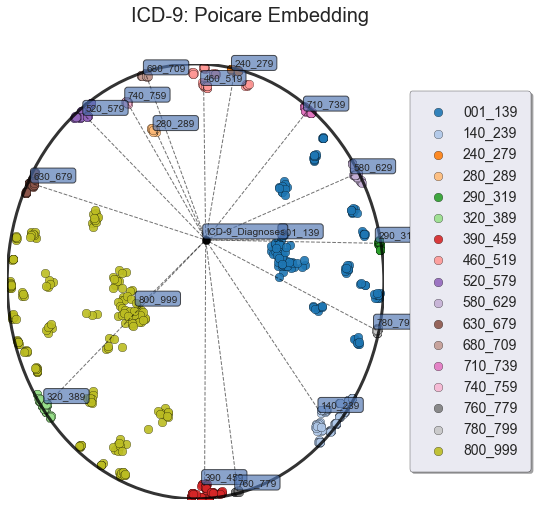

In [23]:
# add labels for chapters and select only high level edges
chapter_emb = emb[emb.node.apply(lambda x: x in list(chapter_range_name.keys()))]
chapter_emb_dict = dict(zip(chapter_emb.node.values, chapter_emb.iloc[:, 1:3].values))
chapter_edges = [e for e in edge_list if 'ICD-9_Diagnoses' in e]

plot_poincare_icd(emb, labels, edge_list=chapter_edges, add_labels=True,
                  label_dict=chapter_emb_dict, edge_frac=1, plot_frac=1, label_frac=0,
                  legend_headers=chapter_label_range, save=False)

## Evaluate Hyperbolic Embeddings

A good embedding of the ICD-9 taxonomy will preserve the hierarchical relationships between entities (diagnosis codes). Working with the embeddings in the poincare disk, we compute the pairwise hyperbolic distances between points within the same chapter or subchapter, and then we compare these with the hyperbolic distances between different chapters and subchapters. If points within the same diagnosis group are closer together in hyperbolic space, relative to the intergroup distances, then our embedding will have preserved similarities and hierarchical relationships in the ICD-9 taxonomy.  

In [140]:
def get_chapter_nodes(chapter, edge_list):
    """ Return the set of nodes within a given chapter
    Parameters
    ----------
    chapter : must be given in range notation, e.g. '001_139'
    edge_list: list of [u, v] edge pairs
    """
    child_nodes = [e[0] for e in edge_list if e[1] == chapter]
    return child_nodes

def within_chapter_distances(chapter_nodes, embedding_dict):
    # compute all pairwise hyperbolic distances
    D = poincare_distances(np.array([embedding_dict[x] for x in chapter_nodes]))
    mean_dist = D[D>0].mean()
    std_dev = D[D>0].std()
    return [mean_dist, std_dev]

within_chapter_metrics = {'mean_dists': [], 'std_dev': []}
for chapter in chapter_range_name.keys():
    chapter_nodes = get_chapter_nodes(chapter, edge_list)
    mean, std = within_chapter_distances(chapter_nodes, emb_dict)
    within_chapter_metrics['mean_dists'].append(mean)
    within_chapter_metrics['std_dev'].append(std)
print('mean_distance_within_chapter: ', np.mean(within_chapter_metrics['mean_dists']))
print('mean_std_dev_within_chapter: ', np.mean(within_chapter_metrics['std_dev']))

mean_distance_within_chapter:  1.701536007450394
mean_std_dev_within_chapter:  1.0215706570578436


In [141]:
def get_subchapter_nodes(subchapter, edge_list):
    """ Return the set of nodes within a given subchapter
    Parameters
    ----------
    subchapter : must be given in range notation, e.g. '001_007'
    edge_list: list of [u, v] edge pairs
    """
    child_nodes = [e[0] for e in edge_list if e[1] == subchapter]
    return child_nodes

def within_subchapter_distances(subchapter_nodes, embedding_dict):
    # compute all pairwise hyperbolic distances
    if len(subchapter_nodes) <= 1:
        return
    else:
        D = poincare_distances(np.array([embedding_dict[x] for x in subchapter_nodes]))
        mean_dist = D[D>0].mean()
        std_dev = D[D>0].std()
    return [mean_dist, std_dev]

within_subchapter_metrics = {'mean_dists': [], 'std_dev': []}
for subchapter in subchapter_range_name.keys():
    subchapter_nodes = get_subchapter_nodes(subchapter, edge_list)
    if len(subchapter_nodes) <= 1:
        continue
    else:
        mean, std = within_subchapter_distances(subchapter_nodes, emb_dict)
        within_subchapter_metrics['mean_dists'].append(mean)
        within_subchapter_metrics['std_dev'].append(std)
print('mean_distance_within_subchapter: ', np.mean(within_subchapter_metrics['mean_dists']))
print('mean_std_dev_within_subchapter: ', np.mean(within_subchapter_metrics['std_dev']))

mean_distance_within_subchapter:  0.25529391642250965
mean_std_dev_within_subchapter:  0.13769563165037338


In [142]:
# define global variable to save redundant computations
D = poincare_distances(emb_data)
D_symm = D.T + D

def between_chapter_distances(chapter_nodes, embedding):
    # compute all pairwise hyperbolic distances
    embedding = embedding[embedding.node != 'ICD-9_Diagnoses'].reset_index(drop=True)
    in_group_indices = embedding[embedding.node.apply(lambda x: x in chapter_nodes)].index
    rows = np.arange(0, D_symm.shape[0])
    out_group_indices = list(set(rows).difference(in_group_indices))
    between_dists = [D_symm[ix, out_group_indices] for ix in in_group_indices]
    mean_dist = np.mean(between_dists)
    std_dev = np.std(between_dists)
    return [mean_dist, std_dev]

between_chapter_metrics = {'mean_dists': [], 'std_dev': []}
for chapter in chapter_range_name.keys():
    chapter_nodes = get_chapter_nodes(chapter, edge_list)
    mean, std = between_chapter_distances(chapter_nodes, emb)
    between_chapter_metrics['mean_dists'].append(mean)
    between_chapter_metrics['std_dev'].append(std)
print('mean_distance_between_chapters: ', np.mean(between_chapter_metrics['mean_dists']))
print('mean_std_dev_between_chapters: ', np.mean(between_chapter_metrics['std_dev']))

mean_distance_between_chapters:  7.306962539704587
mean_std_dev_between_chapters:  2.0357280105541906


In [143]:
def between_subchapter_distances(subchapter_nodes, embedding):
    # compute all pairwise hyperbolic distances
    embedding = embedding[embedding.node != 'ICD-9_Diagnoses'].reset_index(drop=True)
    in_group_indices = embedding[embedding.node.apply(lambda x: x in subchapter_nodes)].index
    rows = np.arange(0, D_symm.shape[0])
    out_group_indices = list(set(rows).difference(in_group_indices))
    between_dists = [D_symm[ix, out_group_indices] for ix in in_group_indices]
    mean_dist = np.mean(between_dists)
    std_dev = np.std(between_dists)
    return [mean_dist, std_dev]

between_subchapter_metrics = {'mean_dists': [], 'std_dev': []}
for subchapter in subchapter_range_name.keys():
    subchapter_nodes = get_subchapter_nodes(subchapter, edge_list)
    if len(subchapter_nodes) <= 1:
        continue
    else:
        mean, std = between_subchapter_distances(subchapter_nodes, emb)
        between_subchapter_metrics['mean_dists'].append(mean)
        between_subchapter_metrics['std_dev'].append(std)
print('mean_distance_between_subchapters: ', np.mean(between_subchapter_metrics['mean_dists']))
print('mean_std_dev_between_subchapters: ', np.mean(between_subchapter_metrics['std_dev']))

mean_distance_between_subchapters:  6.871264440887097
mean_std_dev_between_subchapters:  2.1249803097042688


In [151]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Category", "Within Category", "Outside Category"]
v1 = np.round(np.mean(within_chapter_metrics['mean_dists']), 3)
v2 = np.round(np.mean(within_chapter_metrics['std_dev']), 3)
v3 = np.round(np.mean(within_subchapter_metrics['mean_dists']), 3)
v4 = np.round(np.mean(within_subchapter_metrics['std_dev']), 3)
v5 = np.round(np.mean(between_chapter_metrics['mean_dists']), 3)
v6 = np.round(np.mean(between_chapter_metrics['std_dev']), 3)
v7 = np.round(np.mean(between_subchapter_metrics['mean_dists']), 3)
v8 = np.round(np.mean(between_subchapter_metrics['std_dev']), 3)

x.add_row(["Chapter", str(v1) + ' (' + str(v2) + ')', str(v5) + ' (' + str(v6) + ')'])
x.add_row(["Sub-chapter", str(v3) + ' (' + str(v4) + ')', str(v7) + ' (' + str(v8) + ')'])
print(x)

+-------------+-----------------+------------------+
|   Category  | Within Category | Outside Category |
+-------------+-----------------+------------------+
|   Chapter   |  1.702 (1.022)  |  7.307 (2.036)   |
| Sub-chapter |  0.255 (0.138)  |  6.871 (2.125)   |
+-------------+-----------------+------------------+


## Apply Hyperbolic K-Means Clustering to Poincare Embeddings

In [24]:
# fit hyperbolic kmeans clusters to embedding vectors
sys.path.append('C:\\Users\\dreww\\Desktop\\hyperbolic-learning\\hyperbolic_kmeans')
from hkmeans import HyperbolicKMeans, plot_clusters
hkmeans = HyperbolicKMeans(n_clusters=17)
hkmeans.fit(emb_data, max_epochs=5)

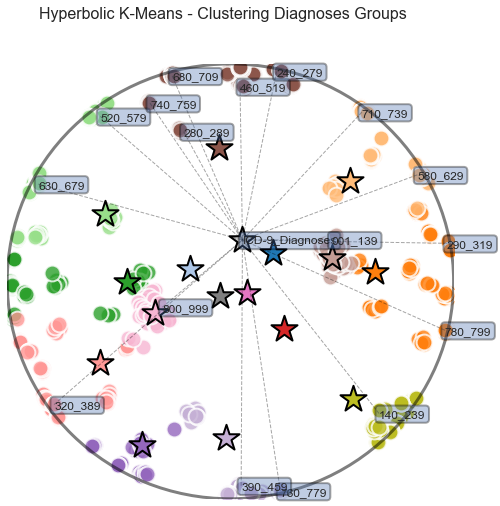

In [25]:
# plot results
plot_clusters(emb, labels = hkmeans.assignments, centroids = hkmeans.centroids, edge_list=chapter_edges,
              add_labels=True, label_dict=chapter_emb_dict, label_frac = 0.001, edge_frac = 1,
              width=8, height=8, title='Clustering Diagnoses Groups')

___
### References: <br>


**[1]**. Weng, Wei-Hung and Peter Szolovits. “Representation Learning for Electronic Health Records.” ArXiv abs/1909.09248 (2019): n. pag.

**[2]** Beaulieu-Jones, Brett & Kohane, Isaac & Beam, Andrew. (2019). Learning Contextual Hierarchical Structure of Medical Concepts with Poincairé Embeddings to Clarify Phenotypes. Pacific Symposium on Biocomputing. Pacific Symposium on Biocomputing. 24. 8-17. 

**[3]** Cao, Jiazhen. “A Case Study for Predicting in-Hospital Mortality by Utilizing the Hyperbolic Embedding of ICD-9 Medical Ontology.” (2019).

**[4]** Learning Electronic Health Records through Hyperbolic Embedding of Medical Ontologies: https://dl.acm.org/doi/pdf/10.1145/3307339.3342148

<br>
___